# Basics

In [1]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

RSEED=33

In [2]:
# load data

original_train = pd.read_csv('data/Train.csv')
original_test = pd.read_csv('data/Test.csv')
variables = pd.read_csv('data/VariableDefinitions.csv')

## Data Cleaning, Preprocessing

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In [4]:
# rename columns
original_train.columns = ["country", "year", "uniqueid", "bank_account", "location", "cellphone", "household", "age", "gender", "status_household", "marital_status", "education", "job"]
original_train.head(2)

,country,year,uniqueid,bank_account,location,cellphone,household,age,gender,status_household,marital_status,education,job
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent


In [5]:
#convert target variable to numeric
le = LabelEncoder()
original_train['bank_account'] = le.fit_transform(original_train['bank_account'])

In [6]:
#Separate training features from target
X_train = original_train.drop(['bank_account'], axis=1)
y_train = original_train['bank_account']

In [7]:
# drop unnecessary columns
X_train = X_train.drop(["uniqueid", "year"], axis=1)

# dummies for nominal data
country_dummies = pd.get_dummies(X_train['country'], prefix='country', drop_first=True)
location_dummies = pd.get_dummies(X_train['location'], prefix='location', drop_first=True)
cellphone_dummies = pd.get_dummies(X_train['cellphone'], prefix='cellphone', drop_first=True)
gender_dummies = pd.get_dummies(X_train['gender'], prefix='gender', drop_first=True)
marital_status_dummies = pd.get_dummies(X_train['marital_status'], prefix='marital_status', drop_first=True)
job_dummies = pd.get_dummies(X_train['job'], prefix='job', drop_first=True)
status_household_dummies = pd.get_dummies(X_train['status_household'], prefix='status_household', drop_first=True)

# add dummies to data frame
X_train = pd.concat([X_train, country_dummies, location_dummies, cellphone_dummies, gender_dummies, marital_status_dummies, job_dummies, status_household_dummies], axis=1)

# map numerical categories to education level
edu_mapping = {'No formal education': 0, 
               'Primary education' : 2, 
               'Other/Dont know/RTA': 1,
               'Vocational/Specialised training': 4, 
               'Secondary education': 3, 
               'Tertiary education' : 5}

# apply mapping
X_train = X_train.assign(edu_cat = X_train.education.map(edu_mapping))

# drop preprocessed columns
X_train = X_train.drop(['country', 'location', 'cellphone', 'gender', 'marital_status', 'education', 'job', 'status_household'], axis=1)

# scale numerical data
scaler = MinMaxScaler(feature_range=(0, 1))
columns_to_scale = ['household', 'age', 'country_Rwanda', 'country_Tanzania',
       'country_Uganda', 'location_Urban', 'cellphone_Yes', 'gender_Male',
       'marital_status_Dont know', 'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'job_Farming and Fishing', 'job_Formally employed Government',
       'job_Formally employed Private', 'job_Government Dependent',
       'job_Informally employed', 'job_No Income', 'job_Other Income',
       'job_Remittance Dependent', 'job_Self employed',
       'status_household_Head of Household',
       'status_household_Other non-relatives',
       'status_household_Other relative', 'status_household_Parent',
       'status_household_Spouse', 'edu_cat']
processed_X_train = scaler.fit_transform(X_train[columns_to_scale])

## train test split

In [8]:
X_Train, X_Val, y_Train, y_Val = train_test_split(processed_X_train, y_train, stratify = y_train, 
                                                  test_size = 0.3, random_state=RSEED)

## SMOTE

I use Smote for oversampling here because the data set is inbalanced 

In [9]:

from collections import Counter
from numpy import where
from matplotlib import pyplot
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline 

In [10]:
# define smote for oversampling
over = SMOTE(sampling_strategy=0.3, random_state=RSEED)

In [11]:
# apply
X, y = over.fit_resample(X_Train, y_Train)

# Modelling

I'm going to try some models now

## Model 1 Decision Tree

In [12]:
Tree = DecisionTreeClassifier(criterion='gini', max_depth=15, random_state=RSEED)
Tree.fit(X, y) 

DecisionTreeClassifier(max_depth=15, random_state=33)

In [13]:
y_pred_Train_tree = Tree.predict(X)
y_pred_Val_tree = Tree.predict(X_Val)

In [14]:
print('Accuracy Train: ',metrics.accuracy_score(y, y_pred_Train_tree))
print('Accuracy Test: ',metrics.accuracy_score(y_Val, y_pred_Val_tree))
print('F1-score Train: ',metrics.f1_score(y, y_pred_Train_tree, pos_label=1))
print('F1-score Test: ',metrics.f1_score(y_Val, y_pred_Val_tree, pos_label=1))
print('Recall Train: ',metrics.recall_score(y, y_pred_Train_tree, pos_label=1))
print('Recall Test: ',metrics.recall_score(y_Val, y_pred_Val_tree, pos_label=1))

Accuracy Train:  0.9164310569812962
Accuracy Test:  0.8568999716633607
F1-score Train:  0.8006226488519912
F1-score Test:  0.4413716814159292
Recall Train:  0.7271442035815269
Recall Test:  0.4014084507042254


In [15]:
cfm_tree = metrics.confusion_matrix(y_Val, y_pred_Val_tree)

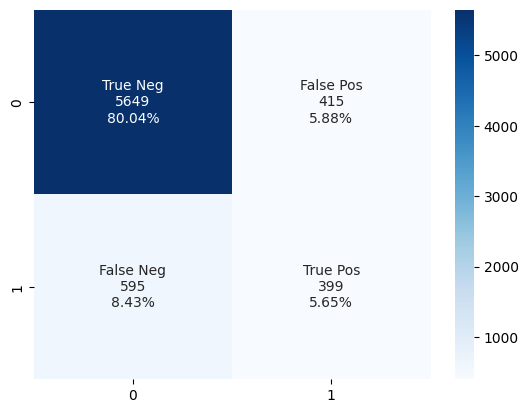

In [16]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cfm_tree.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cfm_tree.flatten()/np.sum(cfm_tree)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cfm_tree, annot=labels, fmt='', cmap='Blues');

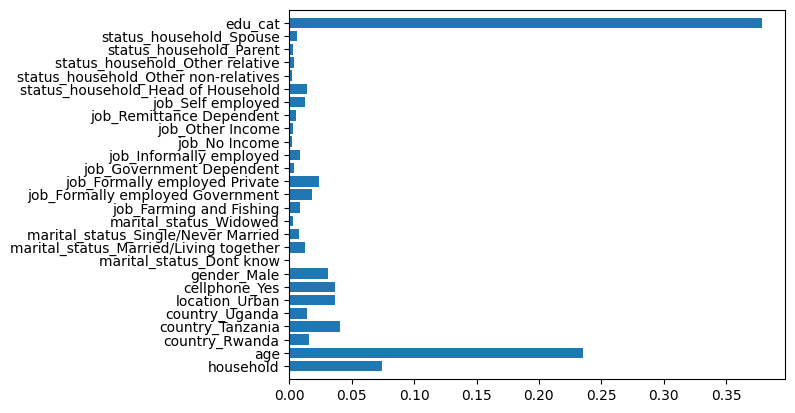

In [17]:
def plot_feature_importances(model):
    n_features = X.shape[1]
    plt.barh(np.arange(n_features),model.feature_importances_, align="center")
    plt.yticks(np.arange(n_features),X_train.columns)
    plt.ylim(-1,n_features)
    
plot_feature_importances(Tree)

## Model 2 Logistic Regression

In [18]:
logreg = LogisticRegression(random_state=RSEED)
logreg.fit(X, y) 

LogisticRegression(random_state=33)

In [19]:
y_pred_Train_log = logreg.predict(X)
y_pred_Val_log = logreg.predict(X_Val)

In [20]:
print('Accuracy Train: ',metrics.accuracy_score(y, y_pred_Train_log))
print('Accuracy Test: ',metrics.accuracy_score(y_Val, y_pred_Val_log))
print('F1-score Train: ',metrics.f1_score(y, y_pred_Train_log, pos_label=1))
print('F1-score Test: ',metrics.f1_score(y_Val, y_pred_Val_log, pos_label=1))
print('Recall Train: ',metrics.recall_score(y, y_pred_Train_log, pos_label=1))
print('Recall Test: ',metrics.recall_score(y_Val, y_pred_Val_log, pos_label=1))

Accuracy Train:  0.8374293170943888
Accuracy Test:  0.8777274015301785
F1-score Train:  0.572123640526617
F1-score Test:  0.493841642228739
Recall Train:  0.47101790763430723
Recall Test:  0.42354124748490946


In [21]:
color_cfm = ['#eaf2f2', '#d9e8e8', '#ccdfdf', '#bcd6d5', "#aacbca", '#9ac1c1', '#83b3b2', '#77abaa', '#6ba4a3', '#5f9c9a', '#599190']

In [22]:
cfm_log = metrics.confusion_matrix(y_Val, y_pred_Val_log)

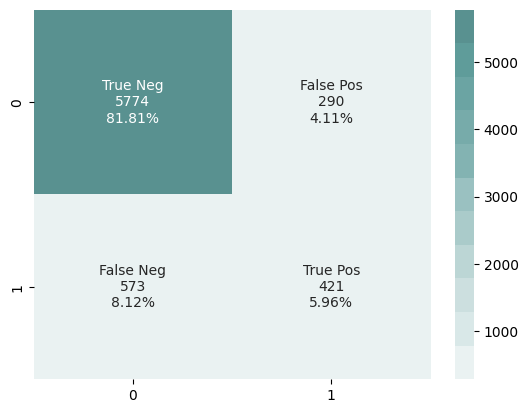

In [23]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cfm_log.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cfm_log.flatten()/np.sum(cfm_log)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cfm_log, annot=labels, fmt='', cmap=color_cfm);

In [24]:
from sklearn.metrics import roc_auc_score, roc_curve
y_pred_Val_log_proba = logreg.predict_proba(X_Val)
y_pred_Val_log_proba = y_pred_Val_log_proba[:, 1]
y_pred_Val_log_proba

array([0.04395324, 0.42204594, 0.30070133, ..., 0.02489482, 0.28246036,
       0.06873519])

In [25]:
fprbl, tprbl, thresholdsbl = roc_curve(y_Val, y_pred_Val_log_proba)

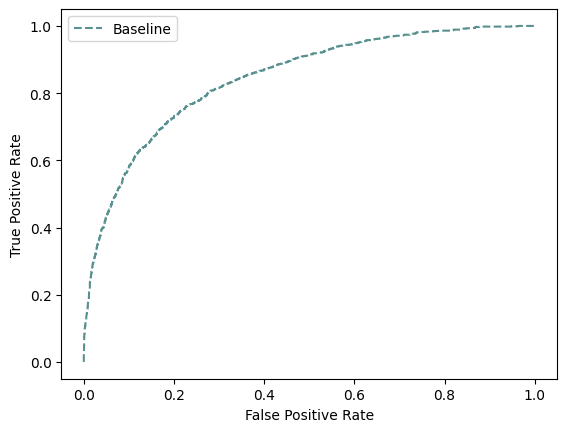

In [26]:
from matplotlib import pyplot
pyplot.plot(fprbl, tprbl, linestyle='--', label='Baseline', color='#599190')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

In [27]:
from sklearn.metrics import roc_auc_score
xgb_auc = roc_auc_score(y_Val, y_pred_Val_log_proba)
xgb_auc

0.8440964885619787

## Model 3 Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
rf = RandomForestClassifier(n_estimators= 1500,
 min_samples_split= 10,
 min_samples_leaf= 1,
 max_features= 'sqrt',
 max_depth= 30,
 bootstrap= False)
rf.fit(X, y) 

RandomForestClassifier(bootstrap=False, max_depth=30, max_features='sqrt',
                       min_samples_split=10, n_estimators=1500)

In [30]:
y_pred_Train_rf = rf.predict(X)
y_pred_Val_rf = rf.predict(X_Val)

In [31]:
print('Accuracy Train: ',metrics.accuracy_score(y, y_pred_Train_rf))
print('Accuracy Test: ',metrics.accuracy_score(y_Val, y_pred_Val_rf))
print('F1-score Train: ',metrics.f1_score(y, y_pred_Train_rf, pos_label=1))
print('F1-score Test: ',metrics.f1_score(y_Val, y_pred_Val_rf, pos_label=1))
print('Recall Train: ',metrics.recall_score(y, y_pred_Train_rf, pos_label=1))
print('Recall Test: ',metrics.recall_score(y_Val, y_pred_Val_rf, pos_label=1))
print('Precision Train: ',metrics.precision_score(y, y_pred_Train_rf, pos_label=1))
print('Precision Test: ',metrics.precision_score(y_Val, y_pred_Val_rf, pos_label=1))

Accuracy Train:  0.9523162244454111
Accuracy Test:  0.8736185888353641
F1-score Train:  0.8909339634373834
F1-score Test:  0.46650717703349287
Recall Train:  0.8440150801131009
Recall Test:  0.39235412474849096
Precision Train:  0.9433763497498024
Precision Test:  0.5752212389380531


In [32]:
cfm_rf = metrics.confusion_matrix(y_Val, y_pred_Val_rf)

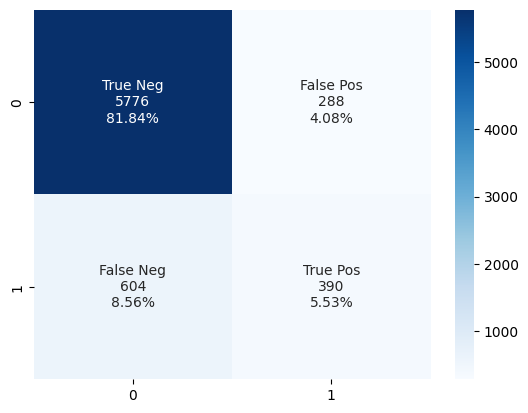

In [33]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cfm_rf.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cfm_rf.flatten()/np.sum(cfm_rf)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cfm_rf, annot=labels, fmt='', cmap='Blues');

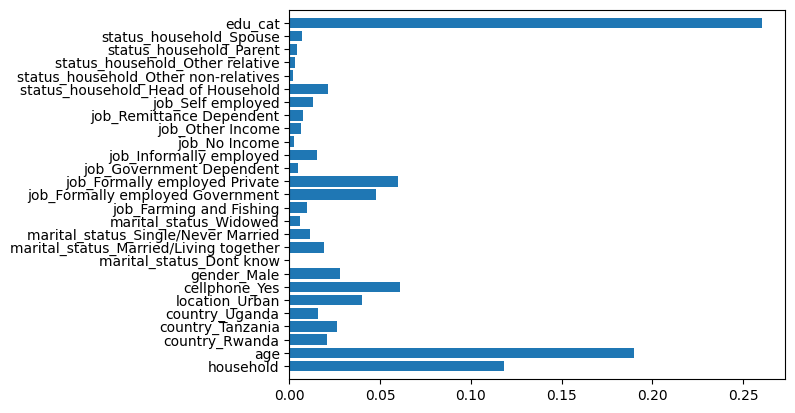

In [34]:
def plot_feature_importances(model):
    n_features = X.shape[1]
    plt.barh(np.arange(n_features),model.feature_importances_, align="center")
    plt.yticks(np.arange(n_features),X_train.columns)
    plt.ylim(-1,n_features)
    
plot_feature_importances(rf)

In [35]:
print(rf.get_params())

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [36]:
from sklearn.model_selection import RandomizedSearchCV

In [37]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [38]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring="accuracy")

In [39]:
# rf_random.fit(X,y)

In [40]:
# rf_random.best_params_

rf_random.best_params_ = {'n_estimators': 1800,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

In [41]:
from sklearn.model_selection import GridSearchCV

In [42]:
param_grid = {
    'bootstrap': [False],
    'max_depth': [20, 30, 40, 50],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [6, 8, 10, 12, 14],
    'n_estimators': [800, 1000, 1500, 1800, 2000]
}

In [43]:
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring="accuracy")

In [44]:
# grid_search.fit(X, y)

In [45]:
# grid_search.best_params_

grid_search.best_params_ = {'bootstrap': False,
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 1500}

## Model 4 KNN

In [46]:
from sklearn.neighbors import KNeighborsClassifier

In [47]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit (X,y)

KNeighborsClassifier(metric='euclidean')

In [48]:
y_pred_Train_knn = rf.predict(X)
y_pred_Val_knn = rf.predict(X_Val)

In [49]:
print('Accuracy Train: ',metrics.accuracy_score(y, y_pred_Train_knn))
print('Accuracy Test: ',metrics.accuracy_score(y_Val, y_pred_Val_knn))
print('F1-score Train: ',metrics.f1_score(y, y_pred_Train_knn, pos_label=1))
print('F1-score Test: ',metrics.f1_score(y_Val, y_pred_Val_knn, pos_label=1))
print('Recall Train: ',metrics.recall_score(y, y_pred_Train_knn, pos_label=1))
print('Recall Test: ',metrics.recall_score(y_Val, y_pred_Val_knn, pos_label=1))
print('Precision Train: ',metrics.precision_score(y, y_pred_Train_knn, pos_label=1))
print('Precision Test: ',metrics.precision_score(y_Val, y_pred_Val_knn, pos_label=1))

Accuracy Train:  0.9523162244454111
Accuracy Test:  0.8736185888353641
F1-score Train:  0.8909339634373834
F1-score Test:  0.46650717703349287
Recall Train:  0.8440150801131009
Recall Test:  0.39235412474849096
Precision Train:  0.9433763497498024
Precision Test:  0.5752212389380531


In [50]:
cfm_knn = metrics.confusion_matrix(y_Val, y_pred_Val_knn)

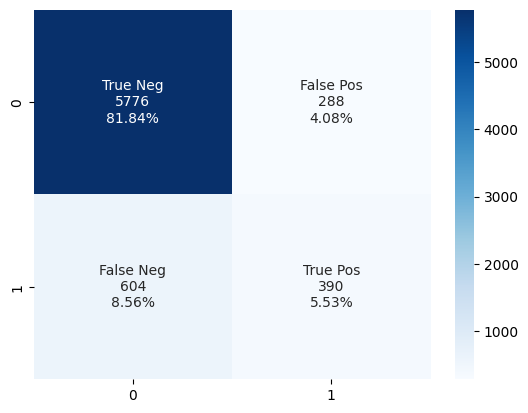

In [51]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cfm_knn.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cfm_knn.flatten()/np.sum(cfm_knn)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cfm_knn, annot=labels, fmt='', cmap='Blues');